Goal: Generate an upset plot for the guide sets used to create scCLEAN
-

In [13]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import upsetplot
from upsetplot import generate_counts, UpSet, plot
import seaborn as sns

pal = sns.color_palette("Set3")
print(pal.as_hex())

['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']


# Create the Violin Plot

In [34]:
# Read the CSV file with aligned reads for the public data to all guide sets
main = pd.read_csv('Aligned_reads_to_guidesets_public_data.csv')
main['Sample'].fillna(method='ffill', inplace=True)

bool_columns = ['rRNA', '90/10 Ribo/Mito', 'Genomic Intervals', '155 Non-Variable Genes']

# Convert the relevant columns to boolean
for col in bool_columns:
    main[col] = main[col].astype(str).str.strip().str.lower().map({'true': True, 'false': False})

    # Check for any unmapped values that may have resulted in NaN
    if main[col].isnull().any():
        print(f"Warning: Unmapped values found in column '{col}'")
        print("Unique values:", main[col].unique())

main = main.set_index(bool_columns)
main = main.drop(columns='Sample')
main

/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_11519/3297228552.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main['Sample'].fillna(method='ffill', inplace=True)
/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_11519/3297228552.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main['Sample'].fillna(method='ffill', inplace=True)


% Aligned Reads
rRNA  90/10 Ribo/Mito Genomic Intervals 155 Non-Variable Genes                 
True  False           False             False                                 3
False True            False             False                                48
True  True            False             False                                51
                      True              False                                60
                                        True                                 69
...                                                                         ...
      False           False             False                                 4
False True            False             False                                26
True  True            False             False                                30
                      True              False                                39
                                        True                                 52

[70 rows x 1 columns]

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

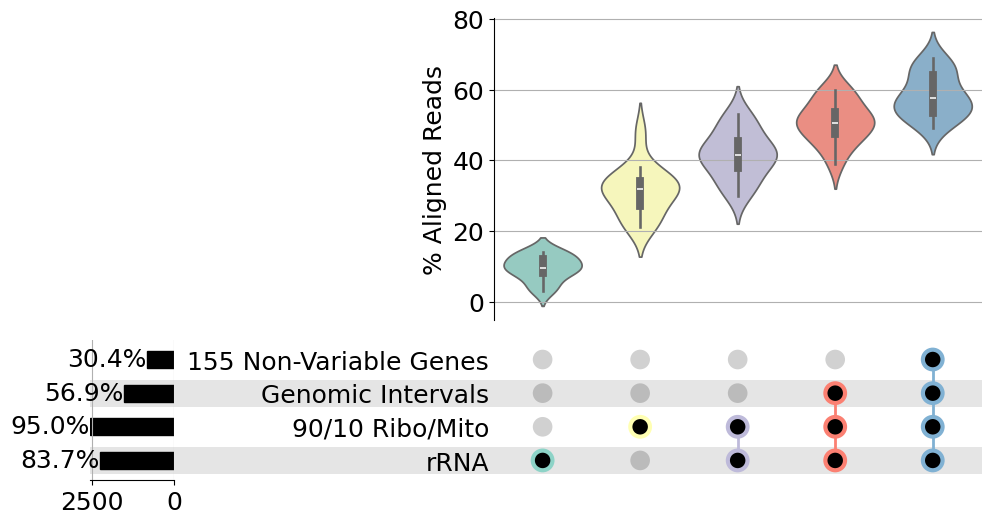

In [35]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(11.5, 6))

upset = UpSet(main, sort_by=None, sort_categories_by=None,subset_size='sum',sum_over='% Aligned Reads',
              shading_color=0.1, element_size=None,show_percentages=True, intersection_plot_elements=0,
             totals_plot_elements=1)

#add the seaborn violin plot
upset.add_catplot(value="% Aligned Reads", kind='violin', palette='Set3',elements=8)

upset.style_subsets(present="rRNA", absent=["90/10 Ribo/Mito","Genomic Intervals","155 Non-Variable Genes"], 
                    edgecolor="#8dd3c7", linewidth=3)
upset.style_subsets(present="90/10 Ribo/Mito", absent=["rRNA","Genomic Intervals","155 Non-Variable Genes"], 
                    edgecolor="#ffffb3", linewidth=3)
upset.style_subsets(present=["90/10 Ribo/Mito","rRNA"], absent=["Genomic Intervals","155 Non-Variable Genes"], 
                    edgecolor="#bebada", linewidth=3)
upset.style_subsets(present=["90/10 Ribo/Mito","rRNA","Genomic Intervals"], absent=["155 Non-Variable Genes"], 
                    edgecolor="#fb8072", linewidth=3)
upset.style_subsets(present=["rRNA", "90/10 Ribo/Mito","Genomic Intervals","155 Non-Variable Genes"],
                    edgecolor="#80b1d3", linewidth=3)

upset.plot(fig=fig)

plt.savefig('Figures/Upset_plot_guide_sets.png',dpi=600)
plt.show()

Now generate the box plot metrics for all of the 5 combinations
-

In [37]:
# get the upset plot intersections
upset = UpSet(main, sort_by=None, sort_categories_by=None,subset_size='sum',sum_over='% Aligned Reads',
              shading_color=0.1, element_size=None,show_percentages=True, intersection_plot_elements=0,
             totals_plot_elements=1)

intersections = upset.intersections.reset_index()
intersections.columns = [col.strip() for col in intersections.columns]  # Clean column names

top_5_groups = intersections.head(5)
results = []

for idx, row in top_5_groups.iterrows():
    conditions = {
        'rRNA': row['rRNA'],
        '90/10 Ribo/Mito': row['90/10 Ribo/Mito'],
        'Genomic Intervals': row['Genomic Intervals'],
        '155 Non-Variable Genes': row['155 Non-Variable Genes']
    }
    group_name = f"Group {idx + 1}: " + ', '.join([f"{k}={v}" for k, v in conditions.items()])
    
    mask = (
        (main.index.get_level_values('rRNA') == conditions['rRNA']) &
        (main.index.get_level_values('90/10 Ribo/Mito') == conditions['90/10 Ribo/Mito']) &
        (main.index.get_level_values('Genomic Intervals') == conditions['Genomic Intervals']) &
        (main.index.get_level_values('155 Non-Variable Genes') == conditions['155 Non-Variable Genes'])
    )
    
    group_data = main[mask]['% Aligned Reads']
    
    # Calculate metrics
    min_value = group_data.min()
    max_value = group_data.max()
    median = group_data.median()
    q1 = group_data.quantile(0.25)
    q3 = group_data.quantile(0.75)
    iqr = q3 - q1
    lower_whisker = max(min_value, q1 - 1.5 * iqr)
    upper_whisker = min(max_value, q3 + 1.5 * iqr)
    
    # Percentiles
    percentiles = group_data.quantile([0.1, 0.9])
    
    # Store the results
    group_result = {
        'Group Name': group_name,
        'Min': min_value,
        'Q1 (25th percentile)': q1,
        'Median (50th percentile)': median,
        'Q3 (75th percentile)': q3,
        'Max': max_value,
        'Lower Whisker': lower_whisker,
        'Upper Whisker': upper_whisker,
        '10th Percentile': percentiles.iloc[0],
        '90th Percentile': percentiles.iloc[1],
        'Data Points': group_data.values.tolist()
    }
    results.append(group_result)

# Write results to a text file
with open('box_plot_metrics_figure1c.txt', 'w') as file:
    for res in results:
        file.write(f"{res['Group Name']}\n")
        file.write(f"Min: {res['Min']}\n")
        file.write(f"Q1 (25th percentile): {res['Q1 (25th percentile)']}\n")
        file.write(f"Median (50th percentile): {res['Median (50th percentile)']}\n")
        file.write(f"Q3 (75th percentile): {res['Q3 (75th percentile)']}\n")
        file.write(f"Max: {res['Max']}\n")
        file.write(f"Lower Whisker: {res['Lower Whisker']}\n")
        file.write(f"Upper Whisker: {res['Upper Whisker']}\n")
        file.write(f"10th Percentile: {res['10th Percentile']}\n")
        file.write(f"90th Percentile: {res['90th Percentile']}\n")
        file.write(f"Data Points: {res['Data Points']}\n")
        file.write("\n")
